# Flood  - Model

<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 07/25/2016 <br/>
</h3>

# Script Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio

from flood_functions import grace_brick_convert_lowres 
from flood_functions import calculate_confusion_matrix_bricks
from flood_functions import calculate_ml_metric_maps
from IPython.display import display, HTML
from scipy import interp

from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [3]:
%pylab inline
#%matplotlib

Populating the interactive namespace from numpy and matplotlib


In [4]:
# define directories
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

# Load Data

## GRACE

In [5]:
# feature bricks
f = open(dir_python_data+'grace_features_lowres.p', 'rb')
grace_features_dict = pickle.load(f)
f.close()

# alter shape
feature_lwe_rank =\
    np.flipud(grace_features_dict['grace_lwe_rank_lowres'].transpose(1,0,2))
feature_lwe_noClim_rank =\
    np.flipud(grace_features_dict['grace_lwe_noClim_rank_lowres'].transpose(1,0,2))
feature_lwe_clim_rank =\
    np.flipud(grace_features_dict['grace_lwe_clim_rank_lowres'].transpose(1,0,2))
    
print"GRACE Feature Brick Shape:", feature_lwe_rank.shape

GRACE Feature Brick Shape: (60, 120, 152)


## Flood Observatory

In [6]:
# flood event brick
f = open(dir_python_data+'flood_event_brick_lowres.p', 'rb')
flood_event_brick = pickle.load(f)
f.close()

# alter shape
flood_event_brick = flood_event_brick[0]
flood_event_brick = np.flipud(flood_event_brick.transpose(1,0,2))
print "Flood Event Brick Shape:",flood_event_brick.shape

Flood Event Brick Shape: (60, 120, 152)


In [7]:
# flood dataframe
df_name = 'df_flood_grace_time_location_features'
df_flood_grace = pd.read_csv(dir_python_data + df_name + '.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)
print "Flood Dataframe Shape:", df_flood_grace.shape

Flood Dataframe Shape: (1977, 41)


# Script Variables

In [8]:
# GRACE
dim = feature_lwe_rank.shape
d1 = dim[0]
d2 = dim[1]
tp = dim[2]

# FO
floods = len(df_flood_grace)

# Model Setup

## Create Labels

In [9]:
label_brick = flood_event_brick
y_labels = label_brick.ravel()

# mask out regions without flood events
mask = ~np.isnan(y_labels)
y_labels = y_labels[mask]
y = y_labels

## Create Features

In [32]:
feature_rand = np.random.random_integers(1,100,len(y))

In [33]:
# convert to percentiles
feature_lwe_perc =\
    ((feature_lwe_rank/tp)*100).ravel()
feature_lwe_noClim_perc =\
    ((feature_lwe_noClim_rank/tp)*100).ravel()
feature_lwe_clim_perc =\
    ((feature_lwe_clim_rank/tp)*100).ravel()

# mask out regions without flood events
feature_lwe_perc = feature_lwe_perc[mask]
feature_lwe_noClim_perc = feature_lwe_noClim_perc[mask]
feature_lwe_clim_perc = feature_lwe_clim_perc[mask]    
    
# create feature matrix
X_features =\
    np.vstack((feature_lwe_perc,            
               feature_lwe_noClim_perc, 
               feature_lwe_clim_perc,
               feature_rand,
              ))

X_features = X_features.transpose()
X = X_features

# Model

## Logistic Regression

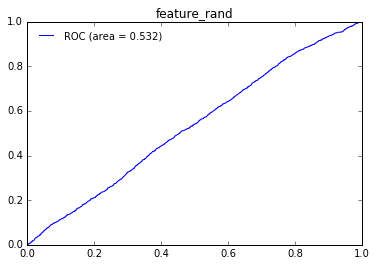

Coefficients: [[ 0.00432859]]


In [46]:
# define data
feature = 'feature_rand'
X_ = X[:,2].reshape(-1, 1)

# fit and predict
clf = LogisticRegression(C=1e10)
clf.fit(X_, y)
probas_ = clf.predict_proba(X_)
y_scores = probas_[:,1]

# roc curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.title(feature)
plt.show()
print 'Coefficients:',clf.coef_

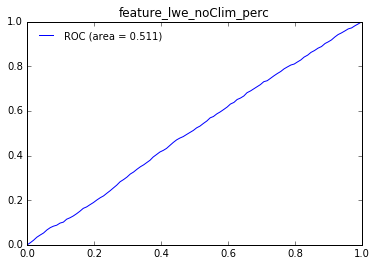

Coefficients: [[-0.00126872]]


In [45]:
# define data
feature = 'feature_lwe_noClim_perc'
X_ = X[:,1].reshape(-1, 1)

# fit and predict
clf = LogisticRegression(C=1e10)
clf.fit(X_, y)
probas_ = clf.predict_proba(X_)
y_scores = probas_[:,1]

# roc curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.title(feature)
plt.show()
print 'Coefficients:',clf.coef_

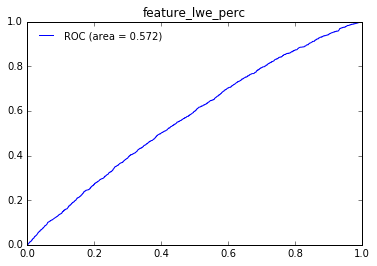

Coefficients: [[ 0.00936346]]


In [44]:
# define data
feature = 'feature_lwe_perc'
X_ = X[:,0].reshape(-1, 1)

# fit and predict
clf = LogisticRegression(C=1e10)
clf.fit(X_, y)
probas_ = clf.predict_proba(X_)
y_scores = probas_[:,1]

# roc curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.title(feature)
plt.show()
print 'Coefficients:',clf.coef_

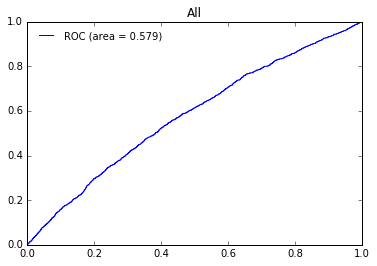

Coefficients: [[ 0.0119371  -0.00124609 -0.00449088  0.01294084]]


In [43]:
# define data (use all features)
feature = 'All'

# fit and predict
clf = LogisticRegression(C=1e10)
clf.fit(X, y)
probas_ = clf.predict_proba(X)
y_scores = probas_[:,1]

# roc curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.title(feature)
plt.show()
print 'Coefficients:',clf.coef_

## Single Decision Tree

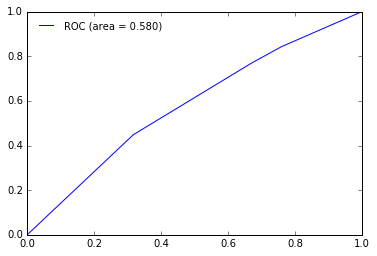

In [19]:
clf = DecisionTreeClassifier(max_depth=2,
                             min_samples_split=400)

probas_ = clf.fit(X, y).predict_proba(X)
y_scores = probas_[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = roc_auc_score(y, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.show()

In [145]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, filled=True, rounded=True, 
                             impurity=False, proportion=True,
                             feature_names=['lwe perc','lwe no-clim perc','lwe clim'])

# terminal command to create pdf
# dot -Tpdf tree.dot -o tree.pdf

IndexError: list index out of range